[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train RF-DETR Object Detection on a Custom Dataset

---

[![hf space](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/SkalskiP/RF-DETR)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-finetune-rf-detr-on-detection-dataset.ipynb)
[![roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/rf-detr)
[![code](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/rf-detr)

RF-DETR is a real-time, transformer-based object detection model architecture developed by Roboflow and released under the Apache 2.0 license.

![rf-detr-coco-rf100-vl-8](https://media.roboflow.com/rf-detr/charts.png)

RF-DETR is the first real-time model to exceed 60 AP on the [Microsoft COCO benchmark](https://cocodataset.org/#home) alongside competitive performance at base sizes. It also achieves state-of-the-art performance on [RF100-VL](https://github.com/roboflow/rf100-vl), an object detection benchmark that measures model domain adaptability to real world problems. RF-DETR is comparable speed to current real-time objection models.

![rf-detr-coco-results-2](https://media.roboflow.com/rf-detr/example_grid.png)

RF-DETR is small enough to run on the edge, making it an ideal model for deployments that need both strong accuracy and real-time performance.

## Environment setup

### Configure API keys

To fine-tune RF-DETR, you need to provide your Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Wed Apr  9 16:11:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Install dependencies

In [3]:
!pip install -q rfdetr==1.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 25.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

### Download example data

In [4]:
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg

## Inference with Pre-trained COCO Model

Loading pretrain weights


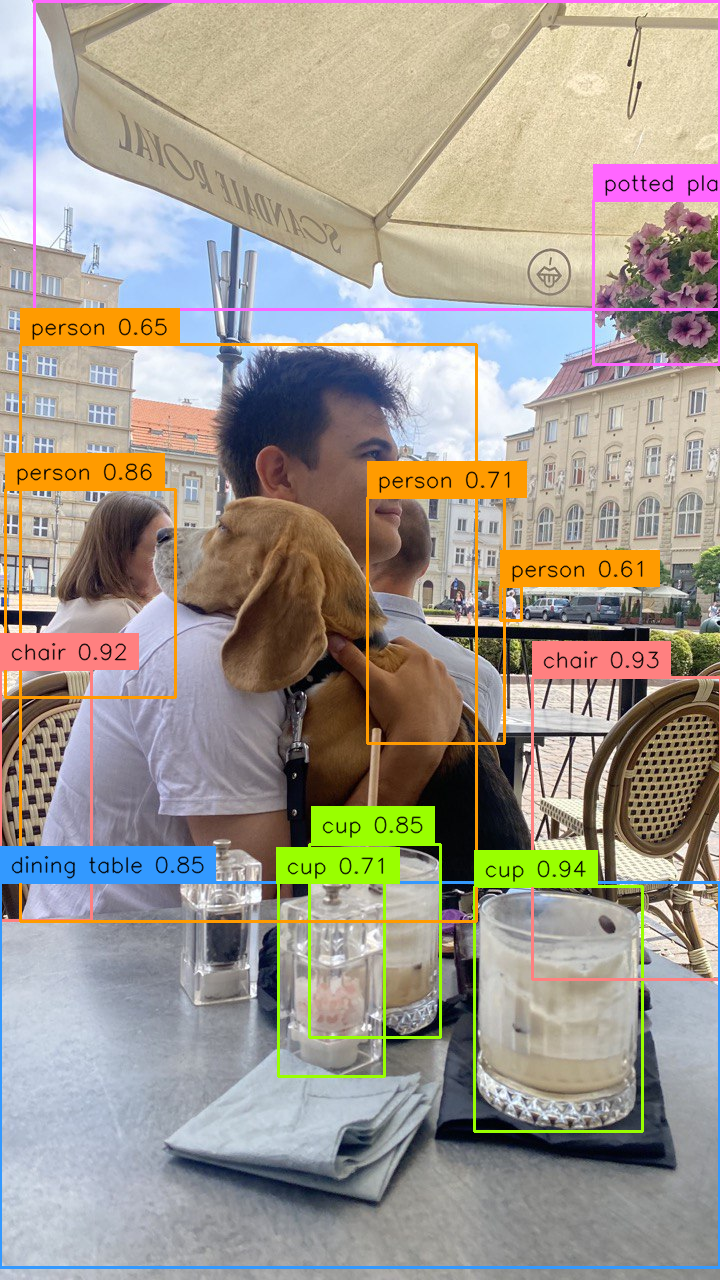

In [6]:
from rfdetr import RFDETRBase
from rfdetr.util.coco_classes import COCO_CLASSES
import supervision as sv
import numpy as np
from PIL import Image

image = Image.open("dog-2.jpeg")

model = RFDETRBase()
detections = model.predict(image, threshold=0.5)

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    smart_position=True
)

labels = [
    f"{COCO_CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = bbox_annotator.annotate(annotated_image, detections)
annotated_image = label_annotator.annotate(annotated_image, detections, labels)
annotated_image

## Download dataset from Roboflow Universe

In [ ]:
from roboflow import download_dataset

dataset = download_dataset("https://universe.roboflow.com/rf100-vl/mahjong-vtacs-mexax-m4vyu-sjtd/dataset/2", "coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to mahjong-vtacs-mexax-m4vyu-sjtd-2 in coco:: 100%|██████████| 2143/2143 [00:03<00:00, 537.66it/s]


## Train RF-DETR on custom dataset

### Choose the right `batch_size`

Different GPUs have different amounts of VRAM (video memory), which limits how much data they can handle at once during training. To make training work well on any machine, you can adjust two settings: `batch_size` and `grad_accum_steps`. These control how many samples are processed at a time. The key is to keep their product equal to 16 — that’s our recommended total batch size. For example, on powerful GPUs like the A100, set `batch_size=16` and `grad_accum_steps=1`. On smaller GPUs like the T4, use `batch_size=4` and `grad_accum_steps=4`. We use a method called gradient accumulation, which lets the model simulate training with a larger batch size by gradually collecting updates before adjusting the weights.

### Train with multiple GPUs

You can fine-tune RF-DETR on multiple GPUs using PyTorch’s Distributed Data Parallel (DDP). Create a `main.py` script that initializes your model and calls `.train()` as usual than run it in terminal.

```bash
python -m torch.distributed.launch \
    --nproc_per_node=8 \
    --use_env \
    main.py
```

Replace `8` in the `--nproc_per_node argument` with the number of GPUs you want to use. This approach creates one training process per GPU and splits the workload automatically. Note that your effective batch size is multiplied by the number of GPUs, so you may need to adjust your `batch_size` and `grad_accum_steps` to maintain the same overall batch size.

In [ ]:
from rfdetr import RFDETRBase

model = RFDETRBase()

model.train(dataset_dir=dataset.location, epochs=15, batch_size=16, grad_accum_steps=1, lr=1e-4)

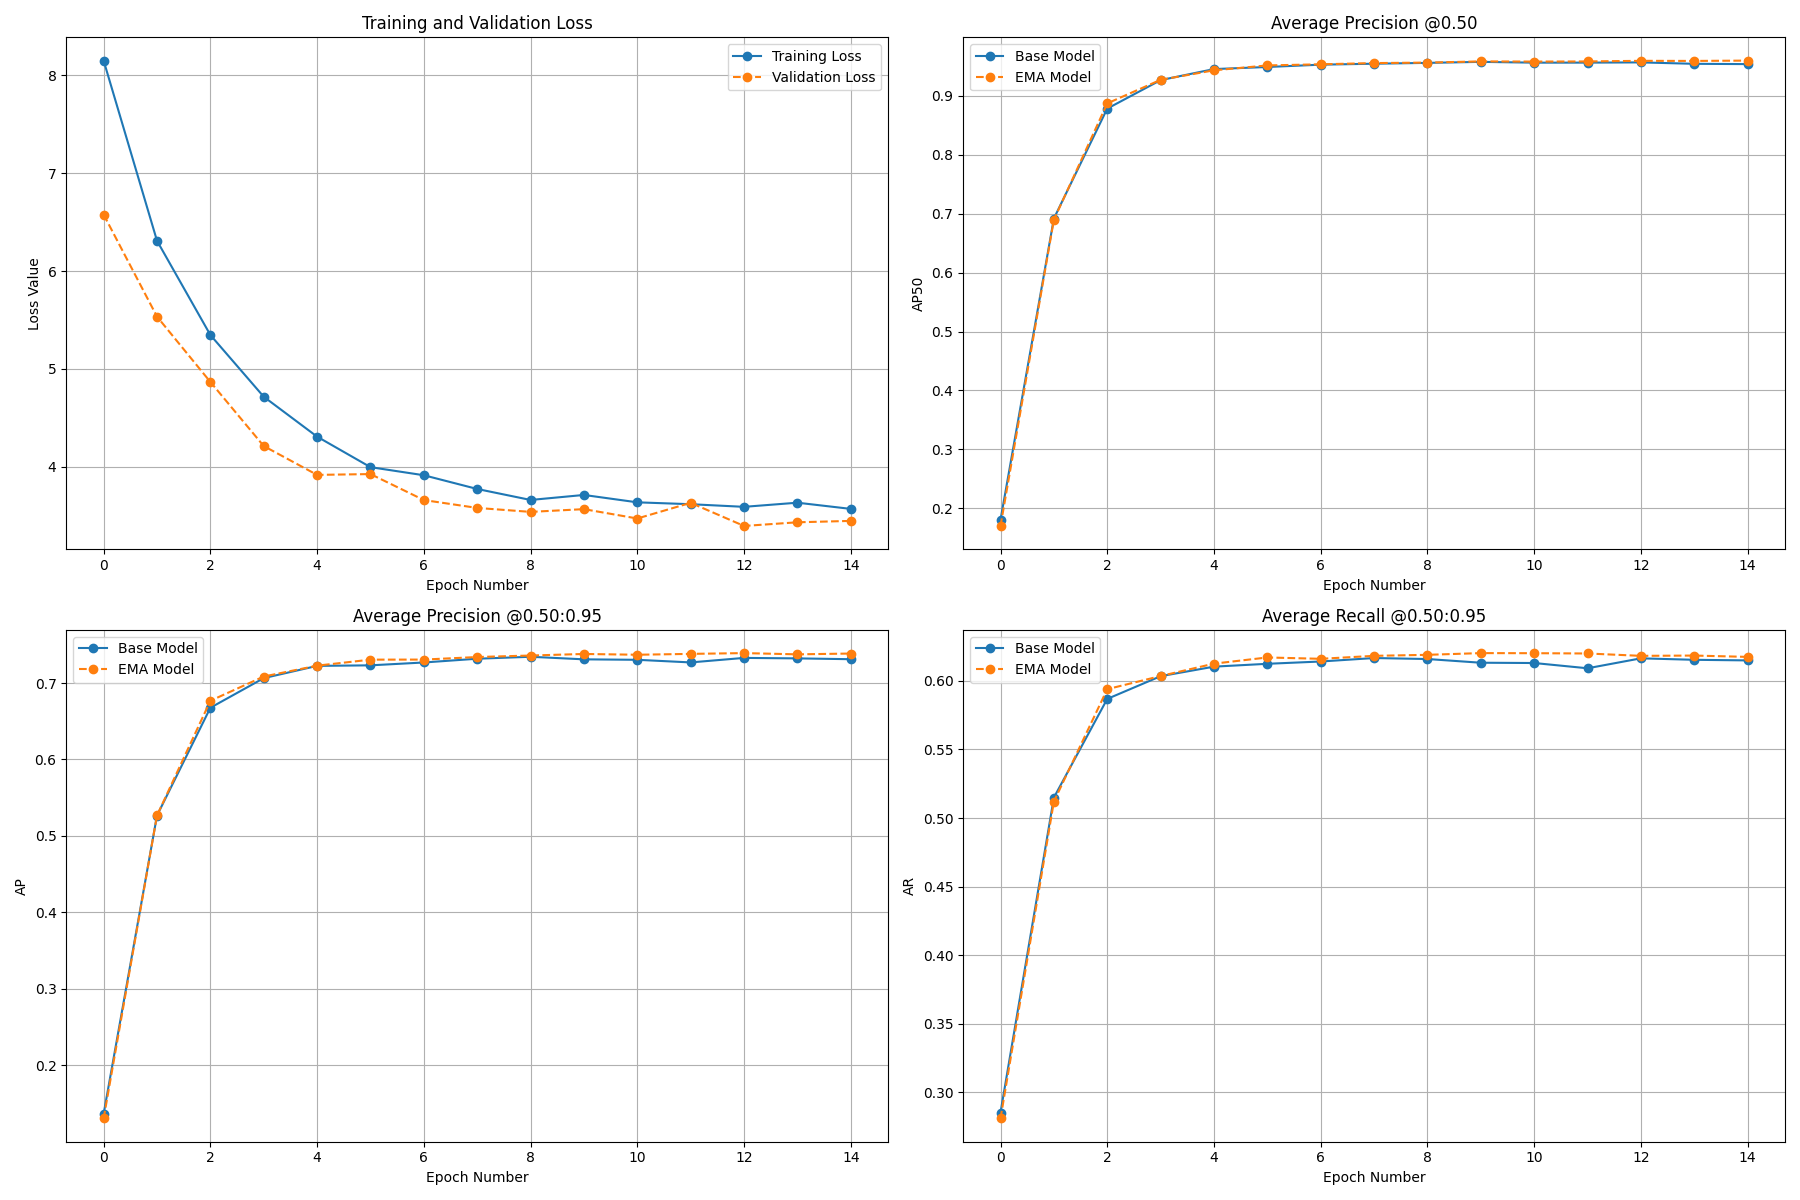

In [ ]:
from PIL import Image

Image.open("/content/output/metrics_plot.png")

## Run inference with fine-tuned model

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

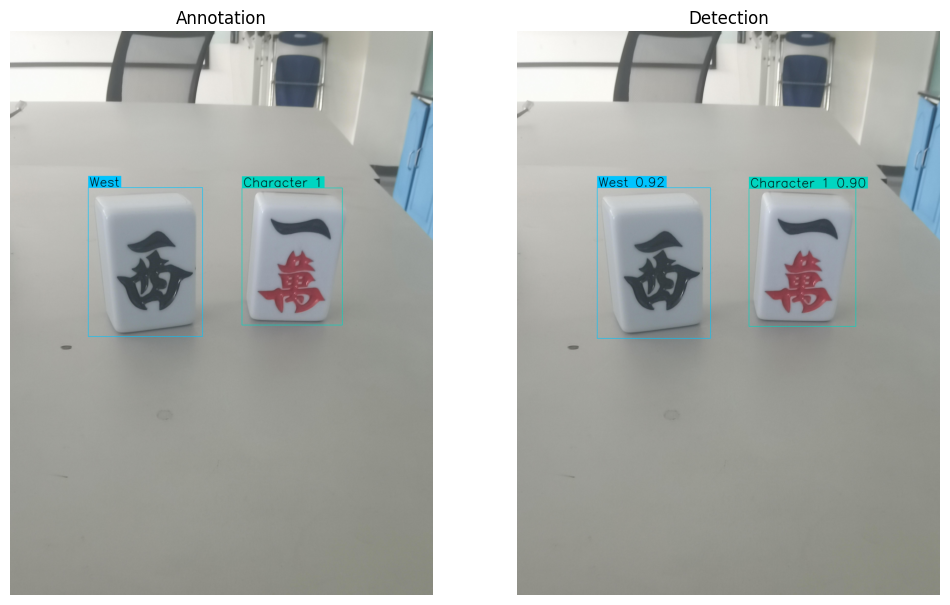

In [ ]:
from rfdetr import RFDETRBase
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    text_thickness=thickness,
    smart_position=True)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

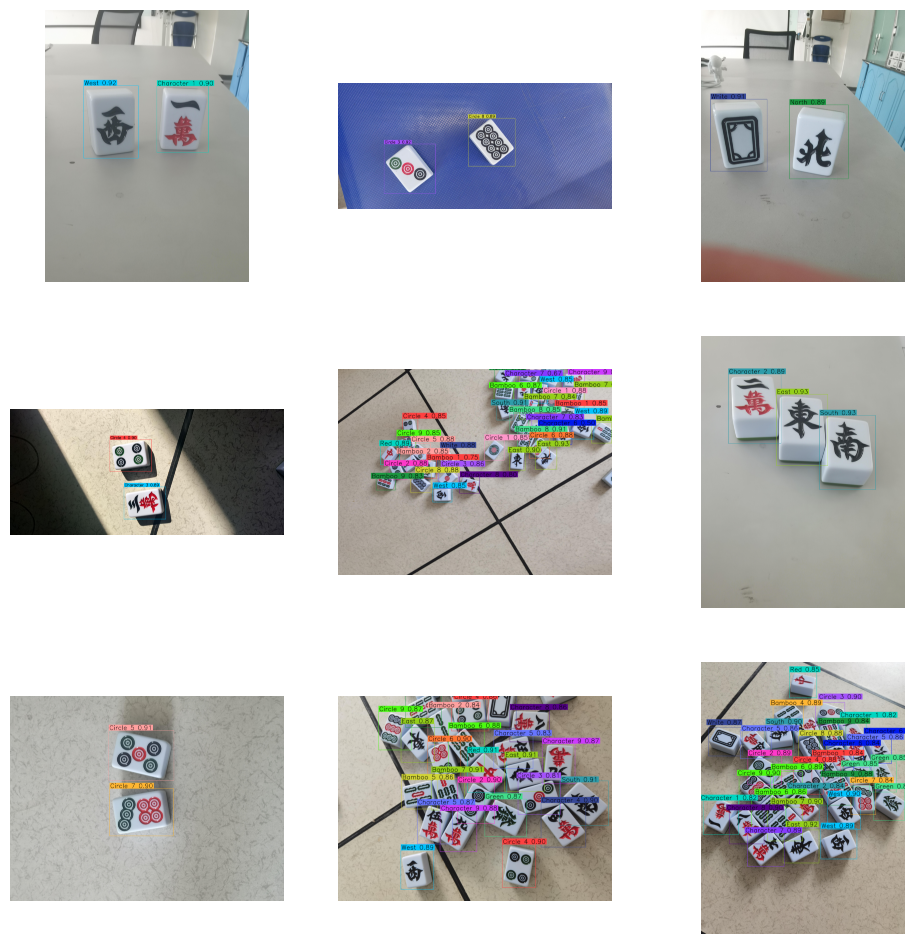

In [ ]:
import supervision as sv
from rfdetr import RFDETRBase
from PIL import Image

detections_images = []

for i in range(9):
    path, image, annotations = ds[i]
    image = Image.open(path)

    detections = model.predict(image, threshold=0.5)

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

    bbox_annotator = sv.BoxAnnotator(thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        text_thickness=thickness,
        smart_position=True)

    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    detections_image = image.copy()
    detections_image = bbox_annotator.annotate(detections_image, detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

    detections_images.append(detections_image)

sv.plot_images_grid(images=detections_images, grid_size=(3, 3), size=(12, 12))

## Evaluate fine-tuned model

In [ ]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0.5)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 214/214 [00:59<00:00,  3.58it/s]


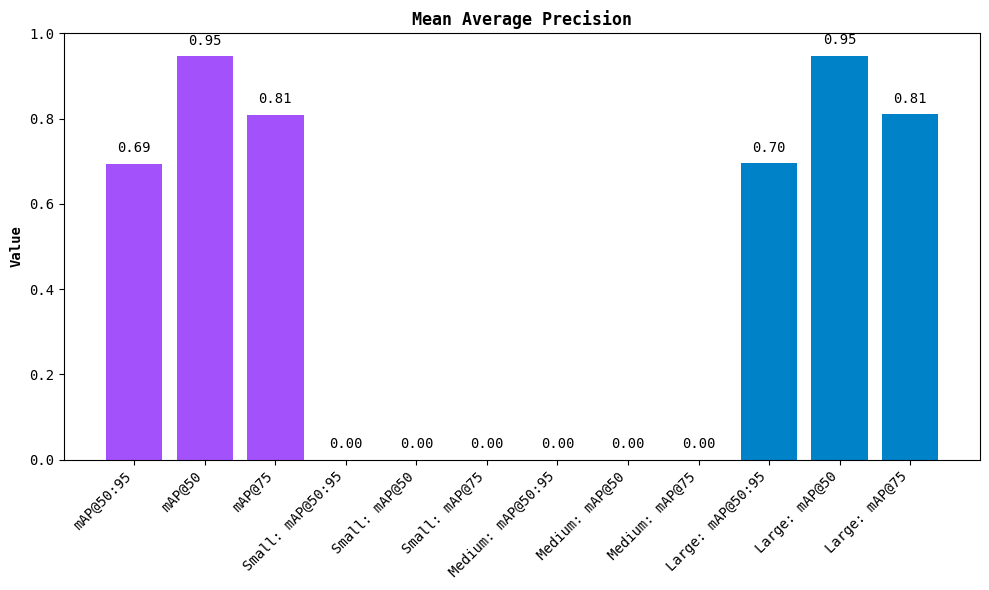

In [ ]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()

map_result.plot()

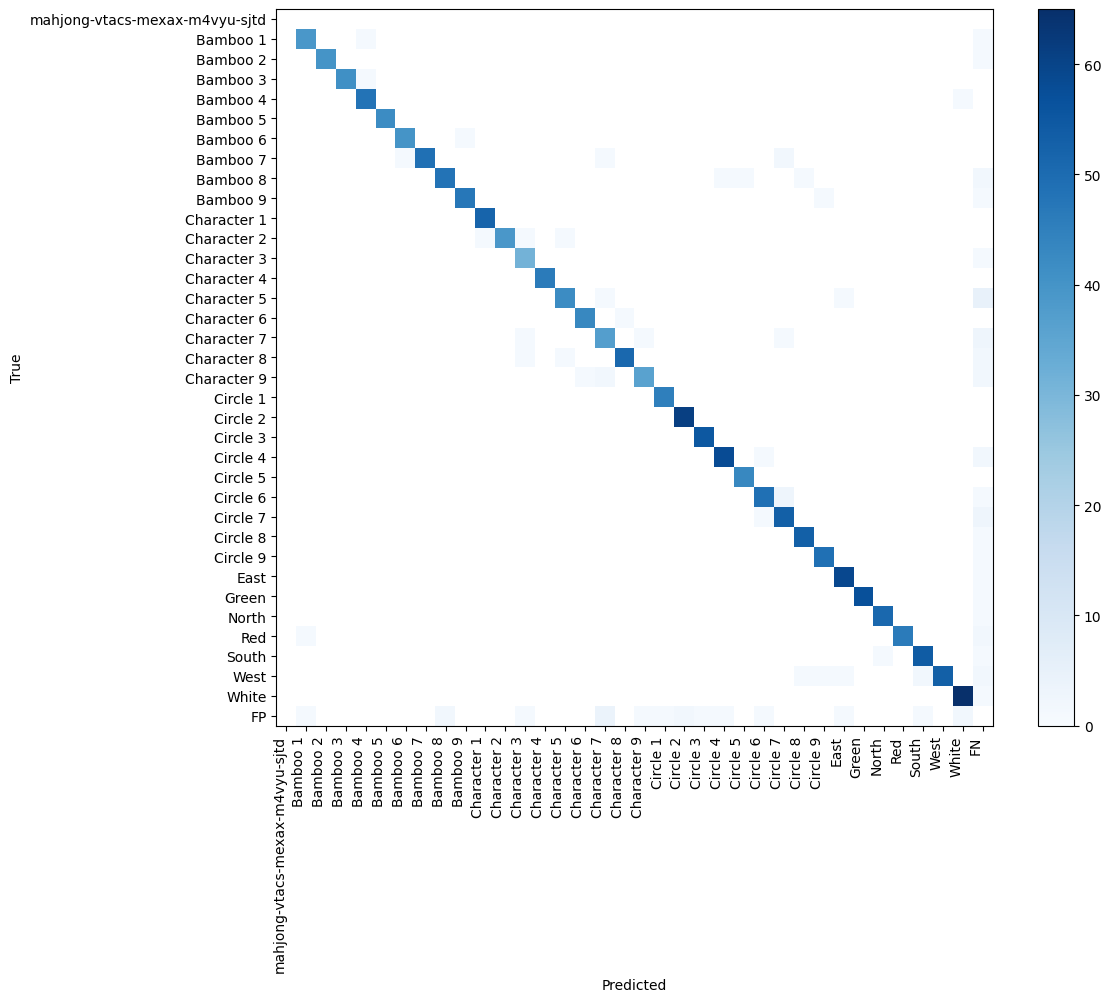

In [ ]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds.classes
)

confusion_matrix.plot()